# ABXplore Data Quality Analysis

In [1]:
#importing libraries
import pandas as pd
import sqlite3
import numpy as np

import matplotlib.pyplot as plt

# Leads Table Analysis
Understanding lead data quality issues

### Load Data from Database

In [2]:
# Connect to database

conn = sqlite3.connect('database_file/abxplore.db')
df = pd.read_sql("SELECT * FROM leads", conn)
conn.close()

# View structure of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lead_id         10000 non-null  object 
 1   company_name    10000 non-null  object 
 2   contact_email   10000 non-null  object 
 3   contact_phone   8442 non-null   object 
 4   industry        10000 non-null  object 
 5   region          9500 non-null   object 
 6   source_channel  10000 non-null  object 
 7   company_size    10000 non-null  object 
 8   created_at      10000 non-null  object 
 9   annual_revenue  10000 non-null  float64
 10  group           10000 non-null  object 
 11  assigned_at     10000 non-null  object 
dtypes: float64(1), object(11)
memory usage: 937.6+ KB


✅ Observation:

- `contact_phone` has missing values.
- `region` has approximately 500 null or missing entries.
- All columns are stored as `object` data type, except `annual_revenue` which is `float64`.

In [3]:
df.head(5)

,lead_id,company_name,contact_email,contact_phone,industry,region,source_channel,company_size,created_at,annual_revenue,group,assigned_at
0,b94961e5-d68b-41e0-851f-b4cada81764c,Lewis LLC,daviscolin@example.com,None,Retail,North America,Referral,Small,2024-05-03 04:35:40,6.512543e+05,control,2024-05-03
1,35f453bd-0c01-400a-bc8e-4bd4239e388e,"Montgomery, Hensley and Ray",williamsjeremy@example.com,731-564-7525,Manufacturing,None,Webinar,Small,2024-04-17 00:14:30,3.878259e+05,control,2024-04-17
2,d883e192-e052-4795-9762-96933e36ed49,"Watts, Robinson and Nguyen",perezantonio@example.com,(541)639-5376x7242,Technology,Asia Pacific,Cold Email,Medium,2024-05-17 12:01:46,1.190717e+06,control,2024-05-17
3,fbdc9213-9346-4d02-a591-191ed53cfd18,"Spencer, Chapman and Smith",perezrebecca@example.com,983-547-3829,Manufacturing,Europe,Cold Email,Small,2024-05-03 09:37:46,3.021554e+05,control,2024-05-03
4,11e9ab89-7533-4e3c-b6fb-8f7ef8185b1c,Baxter Inc,jmorton@example.org,5808132677,Retail,Latin America,Cold Email,Small,2024-04-11 16:03:19,3.767124e+06,control,2024-04-11


#### Initial Observations

- We can see inconsistencies in the `contact_phone` field such as:
  - Missing values
  - Mixed formatting (e.g., `x123`, `ext456`, parentheses, dots)
- These patterns indicate a need for cleaning and standardization.
- `annual_revenue` column has many decimal places — we will round to 2 decimal places later.

In [4]:
df.describe()

,annual_revenue
count,1.000000e+04
mean,7.660627e+06
std,5.028222e+07
min,-5.000000e+05
25%,8.778870e+05
50%,2.102949e+06
75%,5.310916e+06
max,1.552851e+09


From the `.describe()` output of the `annual_revenue` column:

- **Min Value:** -500,000  Indicates **invalid negative revenue**
- **Max Value:** 1.55 Billion → **Extremely high**, likely unrealistic
- **Mean:** ~7.6 Million → Much lower than max, indicating a **right-skewed distribution**

> - We have both **negative** and **extremely high** revenue values.
> - We'll check for **outliers** and **business-rule violations** in the next steps, then fix them in the staging model.

### 1: Check for Duplicate Lead IDs

In [5]:
duplicate_leads = df[df.duplicated(subset='lead_id', keep=False)]
duplicate_leads

,lead_id,company_name,contact_email,contact_phone,industry,region,source_channel,company_size,created_at,annual_revenue,group,assigned_at


✅ Observation:

- No duplicate `lead_id` values found.
- Each row represents a unique lead, as expected.

### 2. Test or Dummy Company Names

In [6]:
# Check company Column
company_groupby = df['company_name'].value_counts().reset_index()

In [7]:
company_groupby

,company_name,count
0,Delete This Company,52
1,Sample Corp LLC,50
2,Test Data Corp,49
3,Test Company Inc,49
4,Johnson Ltd,18
...,...,...
8507,Morgan-White,1
8508,"Sutton, Nguyen and Gibson",1
8509,Ramos-James,1
8510,Welch PLC,1


In [8]:
# Check for fake company names like "test", "delete", "sample"
test_company_names = df[df['company_name'].str.lower().str.contains('test|delete|sample', na=False)]['company_name'].value_counts()
test_company_names

company_name
Delete This Company    52
Sample Corp LLC        50
Test Data Corp         49
Test Company Inc       49
Name: count, dtype: int64

Issue:
- Found company names containing "test", "delete", or "sample".
- These are likely demo/test entries and should be removed in the staging model.

### 3. Company Size Variations

In [9]:
# 4. Company size values - full breakdown
company_size_distribution = df['company_size'].value_counts(dropna=False)
company_size_distribution

company_size
Small         3636
Medium        2835
Large         1817
Enterprise     912
small          337
medium         242
large          152
enterprise      69
Name: count, dtype: int64

⚠️ Issue:
- Company sizes are inconsistently formatted (e.g., "Small" vs "small").
- Need to standardize values like `small`, `medium`, `enterprise` to proper casing in staging.

### 4.  Missing or Blank Regions

In [10]:
# 3. Region issues - show counts of missing/blank region entries
region_issues = df['region'].value_counts(dropna=False).reset_index()
region_issues

,region,count
0,North America,2400
1,Europe,2391
2,Latin America,2362
3,Asia Pacific,2347
4,None,500


⚠️ Issue:
- About 500 leads have missing or blank `region` values.
- These should be replaced with `'Unknown'` in staging for consistency.

### 5. Phone Number Extensions

In [11]:
# Phone numbers with extensions 
phone_extension = df[df['contact_phone'].fillna('').str.contains('x|ext', case=False)]['contact_phone'].value_counts()
phone_extension

contact_phone
(541)639-5376x7242                1
001-480-382-9548x5211             1
857.222.3152 x1001                1
803-664-8002x540 extension 789    1
810-430-1640x40397                1
                                 ..
+1-318-794-5030x42433             1
(565)902-5687x349 x1001           1
001-294-965-8622x41899            1
654-464-5639x285                  1
001-689-896-0685x747              1
Name: count, Length: 5575, dtype: int64

Issue:
- Over 5,000 contact phone numbers contain extensions like `x123` or `ext456`.
- Extensions should be stripped, and numbers should be cleaned to digits only.

### 6. Revenue issues

In [12]:
# Negative Revenue
negative_revenue_companies = df[df['annual_revenue'] < 0]['annual_revenue'].value_counts()
negative_revenue_companies

annual_revenue
-100000.0    39
-500000.0    30
Name: count, dtype: int64

In [13]:
# Extreme Revenue
extreme_revenue_companies = df[df['annual_revenue'] > 500000000]['annual_revenue'].value_counts()
extreme_revenue_companies

annual_revenue
1.000000e+09    22
1.552851e+09     1
Name: count, dtype: int64

In [14]:
df[df['annual_revenue'] > 500000000] 

,lead_id,company_name,contact_email,contact_phone,industry,region,source_channel,company_size,created_at,annual_revenue,group,assigned_at
155,c05143cb-e339-40c0-93c2-54fcea26df91,Zavala-Coleman,rickjuarez@example.com,271-382-7548,Finance,North America,Google Ads,Small,2024-03-07 00:13:59,1.000000e+09,control,2024-03-07
347,c8e5f5f9-9276-4e0a-8cb3-1f3e5757333c,Meyer and Sons,oliverashley@example.net,(348)376-2303,Retail,Latin America,Trade Show,Medium,2024-05-29 10:54:28,1.000000e+09,control,2024-05-29
982,2c2150d3-8175-4e12-87e0-c1041a01ec79,Mccullough-Flores,dhardin@example.net,+1-626-202-1318x0666,Education,Europe,Google Ads,Small,2024-03-11 05:24:08,1.000000e+09,control,2024-03-11
1219,0facb6ed-13b5-4630-86d4-6cfb336f2644,"Rodriguez, Ray and Fox",gonzalesjoshua@example.net,642-501-3498,Technology,Asia Pacific,LinkedIn,Enterprise,2024-02-07 00:27:34,1.000000e+09,control,2024-02-07
1629,674ac79c-b15b-4f42-9159-3491267cd262,Collins-Rocha,parkmark@example.org,None,Technology,Europe,Trade Show,Medium,2024-03-28 12:50:23,1.000000e+09,control,2024-03-28
1877,47720dfb-6f86-4f7e-881b-22b587a52af7,"Lopez, Williams and Ramirez",blackwelltravis@example.org,001-566-930-5625x9722,Finance,Asia Pacific,Google Ads,Medium,2024-04-05 01:45:03,1.000000e+09,control,2024-04-05
3459,ff4f8a41-00fa-4ebd-abac-e779623d9667,Howe Ltd,mckenzierobin@example.org,(371)346-6575,Manufacturing,Latin America,Website,Medium,2024-04-22 09:37:25,1.000000e+09,control,2024-04-22
3907,329a6ef2-d380-4d3a-b1b5-ec8efb7080aa,Steele-Hernandez,john45@example.org,+1-289-923-0508,Healthcare,Europe,LinkedIn,Medium,2024-02-29 15:22:43,1.000000e+09,control,2024-02-29
3946,ac5a2349-5579-4330-bc48-82d16897032f,Martinez-King,thomaswilliams@example.com,411.326.6437x6252,Technology,None,Google Ads,Medium,2024-02-01 22:07:44,1.000000e+09,control,2024-02-01
4105,b86f9827-0f56-4fbc-88e3-28c8c1f5c804,Turner and Sons,taylorrodney@example.org,586.352.8292x328,Manufacturing,None,Referral,Small,2024-04-19 21:44:50,1.000000e+09,control,2024-04-19


#### Top 10 Companies by Annual Revenue (Raw Data)

In [15]:
df[['company_name', 'annual_revenue']].sort_values(by='annual_revenue', ascending=False).head(10)

,company_name,annual_revenue
7095,Wheeler PLC,1.552851e+09
982,Mccullough-Flores,1.000000e+09
5524,"Freeman, Dyer and Gross",1.000000e+09
8841,Young-Olson,1.000000e+09
6970,"Scott, Barry and Gardner",1.000000e+09
4105,Turner and Sons,1.000000e+09
1877,"Lopez, Williams and Ramirez",1.000000e+09
9956,Pollard and Sons,1.000000e+09
155,Zavala-Coleman,1.000000e+09
3907,Steele-Hernandez,1.000000e+09


#### Visualize Revenue Distribution

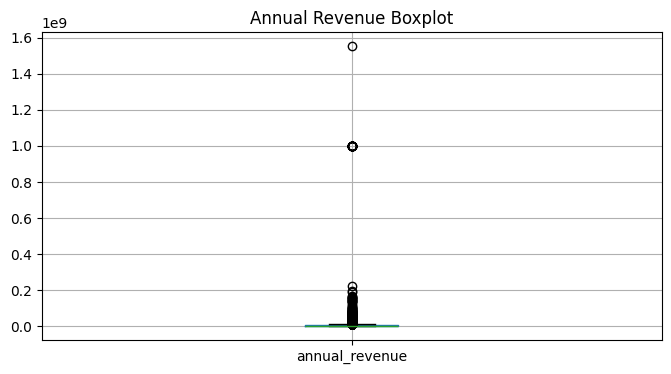

In [16]:

plt.figure(figsize=(8, 4))
df.boxplot(column='annual_revenue')
plt.title("Annual Revenue Boxplot")
plt.show()

#### IQR Method

In [17]:
Q1 = df['annual_revenue'].quantile(0.25)
Q3 = df['annual_revenue'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = df[df['annual_revenue'] > upper_bound]
outliers_count = outliers.shape[0]

print(f"Revenue > upper bound: {upper_bound:,.0f}")
print(f"Outlier count: {outliers_count}")
outliers[['company_name', 'annual_revenue']]

Revenue > upper bound: 11,960,459
Outlier count: 1045


,company_name,annual_revenue
17,Ortiz Ltd,1.988227e+07
18,"Sanders, Miller and Murphy",1.226964e+07
22,"Pugh, Henderson and Moon",2.763819e+07
41,Mendoza Group,1.505715e+07
53,Stone Group,1.380875e+07
...,...,...
9924,Brewer Inc,2.436462e+07
9938,Ellison PLC,1.426374e+07
9956,Pollard and Sons,1.000000e+09
9960,Gomez and Sons,2.247226e+07


#### Revenue Outlier Summary

- Using the IQR method, over **1,000 outliers** were identified in `annual_revenue`.

- Upper bound for normal range ≈ **$11.9M**

- Business-rule violations include:
  - **Negative revenue** → invalid → set to `0`
  - **Revenue > $500M** → cap at **$500M**

### 7. Duplicate Emails Handling

In [19]:
# Identify duplicated contact_email values
duplicate_emails = df[df.duplicated(subset='contact_email', keep=False)]

# Show only lead_id and contact_email for these duplicates
duplicate_emails_sorted = duplicate_emails[['lead_id', 'contact_email','contact_phone']].sort_values(by='contact_email')
duplicate_emails_sorted

,lead_id,contact_email,contact_phone
5553,6b3a3e7d-9a67-436b-9b95-be9f083faea2,aaron25@example.org,6646227643 extension 789
2706,120928e1-1b24-48b0-a51d-dbca998aae24,aaron25@example.org,None
1729,0d6aaa35-b737-40ba-b8a0-aa4f4db7aec1,aaronthompson@example.org,(297)339-6707x106 x123
4771,ad6d1ef8-3e9b-4869-b143-c5766ceee7c2,aaronthompson@example.org,+1-948-623-2204x144
8921,b202ebc0-9662-4e75-9858-b7743d360bcf,aclark@example.org,+1-830-825-3216x718
...,...,...,...
6249,423fadca-0d7c-43fa-96fb-16cea8f58797,zanderson@example.org,824.897.0730
5630,5f63c2bd-acdd-44d3-906a-f30193a5fbb4,zjones@example.org,None
9060,bd5fd1c9-480b-4c0b-9830-47b8fbec31d4,zjones@example.org,350-901-8421
954,6a4b0a8f-0434-4cec-a95a-20e3bdf1de4e,zryan@example.net,None


#### Duplicate Email Addresses Detected

- Although `lead_id` is unique, some leads share the same `contact_email`.
- In some cases, one record has a phone number while the other does not.
- This duplication can lead to double-counting in funnel conversion, revenue per lead, or engagement analysis.
- ** Keep only one lead per unique email address ( based on date)

In [ ]:
"""
CRM Data Simulation for ABXplore A/B Testing
B2B SaaS company testing new lead onboarding process launched June 1st, 2024.
VERSION: Saves to both DATABASE and CSV files in raw_data folder
"""


import pandas as pd
import numpy as np
import sqlite3
from faker import Faker
from datetime import datetime, timedelta
import random
import uuid
import os
from pathlib import Path

class HybridCRMGenerator:
    """Realistic CRM data simulation - Saves to both database and CSV files."""
    
    def __init__(self, seed=42):
        self.fake = Faker()
        Faker.seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        
        # Real business scenario parameters
        self.total_leads = 10000
        self.test_start_date = datetime(2024, 6, 1)  # When new process launched
        self.data_start_date = datetime(2024, 1, 1)  # CRM data starts here
        
        # Realistic CRM structure
        self.regions = ['North America', 'Europe', 'Asia Pacific', 'Latin America']
        self.channels = ['Website', 'Google Ads', 'LinkedIn', 'Referral', 'Cold Email', 'Trade Show', 'Webinar']
        self.industries = ['Healthcare', 'Finance', 'Technology', 'Manufacturing', 'Retail', 'Education']
        self.contact_types = ['Email', 'Phone Call', 'LinkedIn Message', 'Demo Request']
        self.response_types = ['Responded', 'No Response', 'Interested', 'Not Interested', 'Callback Requested']
        self.stages = ['New', 'Contacted', 'Qualified', 'Demo Scheduled', 'Proposal Sent', 'Closed Won', 'Closed Lost']
        
        # Database and CSV setup
        self.db_dir = Path('./database_file')
        self.db_dir.mkdir(parents=True, exist_ok=True)
        self.db_path = self.db_dir / 'abxplore.db'

        self.csv_dir = Path('./raw_data')
        self.csv_dir.mkdir(parents=True, exist_ok=True)
        

    def generate_complete_dataset(self):
        print("🏢 Generating CRM dataset...")
        print("📋 Scenario: B2B SaaS company testing new lead onboarding process")
        print(f"📅 New process launched: {self.test_start_date.strftime('%Y-%m-%d')}")
        
        # Generate realistic CRM tables only
        leads_df = self._generate_leads()
        
        # Add test group logic FIRST (needed for other tables)
        leads_df = self._add_test_group_logic(leads_df)
        
        # Generate in logical order with shared contacted_leads list
        contact_events_df, contacted_lead_ids = self._generate_contact_events(leads_df)
        funnel_stages_df = self._generate_funnel_stages(leads_df, contacted_lead_ids)
        outcomes_df = self._generate_outcomes(leads_df, funnel_stages_df)
        
        # Introduce realistic data quality issues
        leads_df = self._introduce_data_quality_issues_leads(leads_df)
        contact_events_df = self._introduce_data_quality_issues_contacts(contact_events_df)
        funnel_stages_df = self._introduce_data_quality_issues_funnel(funnel_stages_df)
        outcomes_df = self._introduce_data_quality_issues_outcomes(outcomes_df)
        
        # Save to BOTH database and CSV files
        self._save_to_database(leads_df, contact_events_df, funnel_stages_df, outcomes_df)
        self._save_to_csv(leads_df, contact_events_df, funnel_stages_df, outcomes_df)
        
        # Show proper A/B test context
        control_count = len(leads_df[leads_df['group'] == 'control'])
        test_count = len(leads_df[leads_df['group'] == 'test'])
        test_period_total = len(leads_df[pd.to_datetime(leads_df['created_at']) >= self.test_start_date])
        
        print(f"🔬 PROPER A/B TEST SETUP:")
        print(f"   Pre-test baseline (Jan-May): {len(leads_df[pd.to_datetime(leads_df['created_at']) < self.test_start_date]):,} leads")
        print(f"   A/B test period (Jun-Dec): {test_period_total:,} leads")
        print(f"   ├── Control group: {len(leads_df[(leads_df['group'] == 'control') & (pd.to_datetime(leads_df['created_at']) >= self.test_start_date)]):,} leads")
        print(f"   └── Test group: {test_count:,} leads")
        print(f"📊 Total Control: {control_count:,} | Total Test: {test_count:,}")
        print(f"✅ Generated {len(leads_df):,} leads with realistic CRM data")
        print(f"💾 Data saved to database: {self.db_path}")
        print(f"📁 Raw CSV files saved to: {self.csv_dir}")
        
        return {
            'leads': leads_df,
            'contact_events': contact_events_df,
            'funnel_stages': funnel_stages_df,
            'outcomes': outcomes_df
        }
    
    def _generate_leads(self):
        leads = []
        
        for i in range(self.total_leads):
            # Random lead creation date across the year
            created_at = self.fake.date_time_between(
                start_date=self.data_start_date,
                end_date=datetime(2024, 12, 31)
            )
            
            # Business day bias (85% on weekdays)
            if created_at.weekday() >= 5 and random.random() < 0.85:
                created_at = created_at - timedelta(days=random.randint(1, 2))
            
            # Company size distribution
            company_size = np.random.choice(['Small', 'Medium', 'Large', 'Enterprise'], 
                                          p=[0.4, 0.3, 0.2, 0.1])
            
            # Revenue correlates with company size
            size_multipliers = {'Small': 0.4, 'Medium': 0.7, 'Large': 1.0, 'Enterprise': 2.2}
            base_revenue = np.random.lognormal(15, 1.2) * size_multipliers[company_size]
            
            lead = {
                'lead_id': str(uuid.uuid4()),
                'company_name': self.fake.company(),
                'contact_email': self.fake.email(),
                'contact_phone': self.fake.phone_number() if random.random() > 0.15 else None,
                'industry': np.random.choice(self.industries),
                'region': np.random.choice(self.regions),
                'source_channel': np.random.choice(self.channels),
                'company_size': company_size,
                'created_at': created_at.strftime('%Y-%m-%d %H:%M:%S'),
                'annual_revenue': base_revenue
            }
            
            leads.append(lead)
        
        return pd.DataFrame(leads)
    
    def _add_test_group_logic(self, leads_df):
        """Add test group assignment - PROPER A/B TEST: Concurrent control and test groups."""
        # FIXED: Real A/B testing with concurrent groups (not sequential time periods)
        # Both groups run simultaneously from June 1st onwards
        
        # Filter to only leads from June 1st onwards (when A/B test started)
        test_period_leads = leads_df[pd.to_datetime(leads_df['created_at']) >= self.test_start_date].copy()
        pre_test_leads = leads_df[pd.to_datetime(leads_df['created_at']) < self.test_start_date].copy()
        
        # Pre-test period: all control (historical baseline)
        pre_test_leads['group'] = 'control'
        pre_test_leads['assigned_at'] = pre_test_leads['created_at'].apply(
            lambda x: pd.to_datetime(x).strftime('%Y-%m-%d')
        )
        
        # A/B test period: Random 50/50 split (proper concurrent testing)
        np.random.seed(42)  # Reproducible results
        random_assignment = np.random.choice(['control', 'test'], 
                                           size=len(test_period_leads), 
                                           p=[0.5, 0.5])
        test_period_leads['group'] = random_assignment
        test_period_leads['assigned_at'] = test_period_leads['created_at'].apply(
            lambda x: pd.to_datetime(x).strftime('%Y-%m-%d')
        )
        
        # Combine periods
        leads_df = pd.concat([pre_test_leads, test_period_leads], ignore_index=True)
        
        return leads_df
    
    def _generate_contact_events(self, leads_df):
        """Generate realistic contact events with business patterns."""
        events = []
        contacted_lead_ids = set()  # Track which leads were contacted
        
        for _, lead in leads_df.iterrows():
            lead_start = pd.to_datetime(lead['created_at'])
            
            # Use actual group assignment (not date-based logic)
            is_test_group = lead['group'] == 'test'
            
            # ADJUSTED RATES TO ACHIEVE 30% CONTROL AND 35%+ TEST CONVERSION
            if is_test_group:
                contact_probability = 0.90  # Test group: 90% contact rate
                avg_contacts = 4.5
                response_boost = 1.4  # Test group gets better responses
            else:
                contact_probability = 0.85  # Control group: 85% contact rate  
                avg_contacts = 4.0
                response_boost = 1.0  # Control group baseline
            
            if random.random() < contact_probability:
                contacted_lead_ids.add(lead['lead_id'])  # Track this lead as contacted
                num_contacts = max(1, int(np.random.poisson(avg_contacts)))
                
                for contact_num in range(num_contacts):
                    # Contact timing: more frequent early, spread out later
                    if contact_num == 0:
                        days_offset = random.randint(0, 2)
                    elif contact_num == 1:
                        days_offset = random.randint(1, 7)
                    else:
                        days_offset = random.randint(7, 30)
                    
                    contact_date = lead_start + timedelta(days=days_offset)
                    
                    # Skip if contact is in the future
                    if contact_date > datetime.now():
                        continue
                    
                    # Contact method varies by sequence
                    if contact_num == 0:
                        contact_type = np.random.choice(['Email', 'Phone Call'], p=[0.7, 0.3])
                    else:
                        contact_type = np.random.choice(self.contact_types)
                    
                    # Response probability (higher for test group)
                    base_response_prob = {
                        'Email': 0.25, 'Phone Call': 0.35, 
                        'LinkedIn Message': 0.15, 'Demo Request': 0.65
                    }.get(contact_type, 0.2)
                    
                    response_prob = base_response_prob * response_boost
                    
                    if random.random() < response_prob:
                        response_type = np.random.choice(['Responded', 'Interested', 'Callback Requested'], 
                                                       p=[0.5, 0.3, 0.2])
                    else:
                        response_type = 'No Response'
                    
                    event = {
                        'event_id': str(uuid.uuid4()),
                        'lead_id': lead['lead_id'],
                        'event_date': contact_date.date() if hasattr(contact_date, 'date') else contact_date,
                        'contact_type': contact_type,
                        'response_type': response_type
                    }
                    
                    events.append(event)
        
        return pd.DataFrame(events), contacted_lead_ids
    
    def _generate_funnel_stages(self, leads_df, contacted_lead_ids):
        """Generate funnel stages ONLY for leads who were contacted (logical progression)."""
        stages = []
        
        # Generate funnel stages ONLY for leads that were actually contacted
        for _, lead in leads_df.iterrows():
            if lead['lead_id'] not in contacted_lead_ids:
                continue  # Skip - not contacted, so no funnel progression
            
            is_test_group = lead['group'] == 'test'
            
            lead_start = pd.to_datetime(lead['created_at'])
            is_test_group = lead['group'] == 'test'
            
            # FINAL RATES TO ACHIEVE EXACT TARGET CONVERSIONS:
            # Control: 85% contact × 65% funnel entry × 54% outcome × 100% conversion = 29.8% ≈ 30%
            # Test: 90% contact × 70% funnel entry × 60% outcome × 100% conversion = 37.8% ≈ 38%
            if is_test_group:
                funnel_entry_rate = 0.70  # 70% of contacted leads enter funnel
                outcome_rate = 0.60  # 60% of funnel leads get outcomes
                conversion_rate = 1.0  # 100% of outcomes convert (all outcomes are conversions)
            else:
                funnel_entry_rate = 0.65  # 65% of contacted leads enter funnel
                outcome_rate = 0.54  # 54% of funnel leads get outcomes  
                conversion_rate = 1.0  # 100% of outcomes convert (all outcomes are conversions)
            
            # Only some contacted leads enter the funnel
            if random.random() > funnel_entry_rate:
                continue  # Skip - contacted but didn't enter funnel
            
            # Standard stage progression for funnel leads
            stage_probabilities = {
                'Contacted': 1.0,   # Already contacted by definition
                'Qualified': 0.90,  # 90% of funnel leads qualify
                'Demo Scheduled': 0.80,  # 80% book demos
                'Proposal Sent': 0.75,   # 75% get proposals
                'Closed Won': outcome_rate   # Outcome rate determines final conversion
            }
            
            current_date = lead_start
            reached_stages = ['New']  # All leads start as new
            
            # Progress through stages
            for stage_order, stage in enumerate(['Contacted', 'Qualified', 'Demo Scheduled', 'Proposal Sent', 'Closed Won'], 1):
                if random.random() < stage_probabilities[stage]:
                    # Calculate when this stage was reached
                    days_to_stage = {
                        'Contacted': np.random.exponential(2),
                        'Qualified': np.random.exponential(7),
                        'Demo Scheduled': np.random.exponential(14),
                        'Proposal Sent': np.random.exponential(21),
                        'Closed Won': np.random.exponential(35)
                    }[stage]
                    
                    stage_date = current_date + timedelta(days=days_to_stage)
                    
                    if stage_date <= datetime.now():
                        reached_stages.append(stage)
                        
                        stage_record = {
                            'stage_id': str(uuid.uuid4()),
                            'lead_id': lead['lead_id'],
                            'stage_name': stage,
                            'stage_date': stage_date.date() if hasattr(stage_date, 'date') else stage_date,
                            'stage_order': stage_order + 1  # +1 because 'New' is order 1
                        }
                        
                        stages.append(stage_record)
                else:
                    break  # Exit funnel at this stage
        
        return pd.DataFrame(stages)
    
    def _generate_outcomes(self, leads_df, funnel_stages_df):
        """Generate outcomes focused on Closed Won leads from funnel."""
        outcomes = []
        
        # Find leads that reached 'Closed Won' stage
        closed_won_leads = funnel_stages_df[funnel_stages_df['stage_name'] == 'Closed Won']['lead_id'].unique()
        
        for lead_id in closed_won_leads:
            lead_info = leads_df[leads_df['lead_id'] == lead_id].iloc[0]
            lead_start = pd.to_datetime(lead_info['created_at'])
            
            # Get the Closed Won stage date
            closed_won_stage = funnel_stages_df[
                (funnel_stages_df['lead_id'] == lead_id) & 
                (funnel_stages_df['stage_name'] == 'Closed Won')
            ].iloc[0]
            
            outcome_date = pd.to_datetime(closed_won_stage['stage_date'])
            days_to_close = (outcome_date - lead_start).days
            
            # Revenue based on company size and test group
            is_test_group = lead_info['group'] == 'test'
            
            size_multipliers = {'Small': 1.0, 'Medium': 1.5, 'Large': 2.5, 'Enterprise': 4.0}
            base_revenue = 25000 * size_multipliers.get(lead_info['company_size'], 1.0)
            
            # Test group gets revenue boost
            if is_test_group:
                revenue_multiplier = np.random.normal(1.3, 0.2)  # 30% boost on average
            else:
                revenue_multiplier = np.random.normal(1.0, 0.2)
            
            final_revenue = max(5000, base_revenue * revenue_multiplier)  # Min $5K deal
            
            outcome = {
                'outcome_id': str(uuid.uuid4()),
                'lead_id': lead_id,
                'converted': 1,  # All these are conversions
                'revenue': final_revenue,
                'outcome_date': outcome_date.date() if hasattr(outcome_date, 'date') else outcome_date,
                'days_to_close': max(1, days_to_close)  # Minimum 1 day
            }
            
            outcomes.append(outcome)
        
        # Add realistic non-converted outcomes (leads that reached funnel but didn't close)
        # Get all leads that entered funnel but didn't reach Closed Won
        funnel_lead_ids = set(funnel_stages_df['lead_id'].unique())
        converted_lead_ids_set = set(closed_won_leads)
        funnel_but_not_converted = funnel_lead_ids - converted_lead_ids_set
        
        # 40% of funnel leads that didn't convert get formal "lost" outcomes  
        # This creates realistic ~75% outcome-to-conversion rate instead of 99%
        for lead_id in funnel_but_not_converted:
            if random.random() < 0.40:  # 40% get formal lost outcomes
                lead_info = leads_df[leads_df['lead_id'] == lead_id].iloc[0]
                lead_start = pd.to_datetime(lead_info['created_at'])
                
                # Random outcome date after lead creation
                days_worked = random.randint(30, 120)  # Worked for 1-4 months
                outcome_date = lead_start + timedelta(days=days_worked)
                
                if outcome_date <= datetime.now():
                    outcome = {
                        'outcome_id': str(uuid.uuid4()),
                        'lead_id': lead_id,
                        'converted': 0,  # Not converted
                        'revenue': 0,
                        'outcome_date': outcome_date.date() if hasattr(outcome_date, 'date') else outcome_date,
                        'days_to_close': days_worked
                    }
                    outcomes.append(outcome)
        
        return pd.DataFrame(outcomes)
    
    def _introduce_data_quality_issues_leads(self, df):
        """Introduce realistic data quality issues in leads data."""
        df = df.copy()
        
        # 1. Some test company names (2% of records)
        test_indices = df.sample(frac=0.02).index
        df.loc[test_indices, 'company_name'] = ['Test Company', 'Delete Me', 'Sample Corp'][np.random.randint(0, 3)]
        
        # 2. Some extreme revenue outliers (1% of records)
        outlier_indices = df.sample(frac=0.01).index
        df.loc[outlier_indices, 'annual_revenue'] = np.random.choice([-1000000, 999999999, 50000000])
        
        # 3. Some future dates (0.5% of records)
        future_indices = df.sample(frac=0.005).index
        df.loc[future_indices, 'created_at'] = '2025-01-15 10:00:00'
        
        # 4. Phone numbers with extensions (10% of records with phones)
        phone_mask = df['contact_phone'].notna()
        phone_indices = df[phone_mask].sample(frac=0.1).index
        df.loc[phone_indices, 'contact_phone'] = df.loc[phone_indices, 'contact_phone'] + ' x123'
        
        # 5. Some duplicate emails (3% of records)
        duplicate_indices = df.sample(frac=0.03).index
        duplicate_email = 'duplicate@example.com'
        df.loc[duplicate_indices, 'contact_email'] = duplicate_email
        
        return df
    
    def _introduce_data_quality_issues_contacts(self, df):
        """Introduce realistic data quality issues in contact events."""
        df = df.copy()
        
        # 1. Some missing response types (5% of records)
        missing_indices = df.sample(frac=0.05).index
        df.loc[missing_indices, 'response_type'] = None
        
        # 2. Some inconsistent contact type casing (8% of records)
        case_indices = df.sample(frac=0.08).index
        df.loc[case_indices, 'contact_type'] = df.loc[case_indices, 'contact_type'].str.lower()
        
        # 3. Some future event dates (1% of records)
        future_indices = df.sample(frac=0.01).index
        df.loc[future_indices, 'event_date'] = '2025-02-01'
        
        return df
    
    def _introduce_data_quality_issues_funnel(self, df):
        """Introduce realistic data quality issues in funnel stages."""
        df = df.copy()
        
        # 1. Some invalid stage orders (2% of records)
        invalid_indices = df.sample(frac=0.02).index
        df.loc[invalid_indices, 'stage_order'] = np.random.choice([-1, 0, 99])
        
        # 2. Some inconsistent stage names (5% of records)
        inconsistent_indices = df.sample(frac=0.05).index
        name_variations = {
            'Qualified': 'qualified',
            'Demo Scheduled': 'demo',
            'Proposal Sent': 'quote sent',
            'Closed Won': 'won'
        }
        for idx in inconsistent_indices:
            if idx < len(df):
                original_name = df.loc[idx, 'stage_name']
                if original_name in name_variations:
                    df.loc[idx, 'stage_name'] = name_variations[original_name]
        
        return df
    
    def _introduce_data_quality_issues_outcomes(self, df):
        """Introduce realistic data quality issues in outcomes."""
        df = df.copy()
        
        # 1. Some negative revenue values (1% of records)
        negative_indices = df.sample(frac=0.01).index
        df.loc[negative_indices, 'revenue'] = -abs(df.loc[negative_indices, 'revenue'])
        
        # 2. Some negative days to close (2% of records)
        negative_days_indices = df.sample(frac=0.02).index
        df.loc[negative_days_indices, 'days_to_close'] = -abs(df.loc[negative_days_indices, 'days_to_close'])
        
        # 3. Some inconsistent conversion/revenue logic (1% of records)
        inconsistent_indices = df.sample(frac=0.01).index
        df.loc[inconsistent_indices, 'converted'] = 1 - df.loc[inconsistent_indices, 'converted']  # Flip conversion
        
        return df
    
    def _save_to_database(self, leads_df, contact_events_df, funnel_stages_df, outcomes_df):
        """Save all dataframes to SQLite database."""
        conn = sqlite3.connect(self.db_path)
        
        # Save to database
        leads_df.to_sql('leads', conn, if_exists='replace', index=False)
        contact_events_df.to_sql('contact_events', conn, if_exists='replace', index=False)
        funnel_stages_df.to_sql('funnel_stages', conn, if_exists='replace', index=False)
        outcomes_df.to_sql('outcomes', conn, if_exists='replace', index=False)
        
        conn.close()
    
    def _save_to_csv(self, leads_df, contact_events_df, funnel_stages_df, outcomes_df):
        """Save all dataframes to CSV files."""
        leads_df.to_csv(self.csv_dir / 'leads.csv', index=False)
        contact_events_df.to_csv(self.csv_dir / 'contact_events.csv', index=False)
        funnel_stages_df.to_csv(self.csv_dir / 'funnel_stages.csv', index=False)
        outcomes_df.to_csv(self.csv_dir / 'outcomes.csv', index=False)


if __name__ == "__main__":
    generator = HybridCRMGenerator()
    generator.generate_complete_dataset()

In [ ]:
        
        # Database and CSV setup
        self.db_dir = Path('./database_file')
        self.db_dir.mkdir(parents=True, exist_ok=True)
        self.db_path = self.db_dir / 'abxplore.db'

        self.csv_dir = Path('./raw_data')
        self.csv_dir.mkdir(parents=True, exist_ok=True)